# Image-to-Image Translation Using Pix2Pix

This project implements an Image-to-Image Translation system using Pix2Pix like architecture with a U-net generator and PatchGAN descriminator, a kind of cGAN based model. The goal of the project is to transform input sketches of buildings into realistic images by training the generator-discriminator pair.
  
The model pairs the input (sketch) with the desired output (a realistic version of the sketch) so that the generator learns to create realistic images from sketches, while the discriminator evaluates the quality of the generated images by distinguishing between real and fake image pairs.

In [19]:
#importing libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import time
import tensorflow_addons as tfa 

# Data preparation

The dataset is already split into 20/80 train and test subsets.

In [7]:
# realistic images
# training data
train_images_realistes_paths = [f'trainA/{img_file}' for img_file in os.listdir('trainA')]
# testing data
test_images_realistes_paths = [f'testA/{img_file}' for img_file in os.listdir('testA')]

In [9]:
print(f"Training real images: {len(train_images_realistes_paths)}")
print(f"Testing real images: {len(test_images_realistes_paths)}")

Training real images: 400
Testing real images: 106


In [11]:
# sketch images
# training data
train_croquis_paths = [f'trainB/{img_file}' for img_file in os.listdir('trainB')]
# testing data
test_croquis_paths = [f'testB/{img_file}' for img_file in os.listdir('testB')]

In [13]:
print(f"Training sketch images: {len(train_croquis_paths)}")
print(f"Testing sketch images: {len(test_croquis_paths)}")

Training sketch images: 400
Testing sketch images: 106


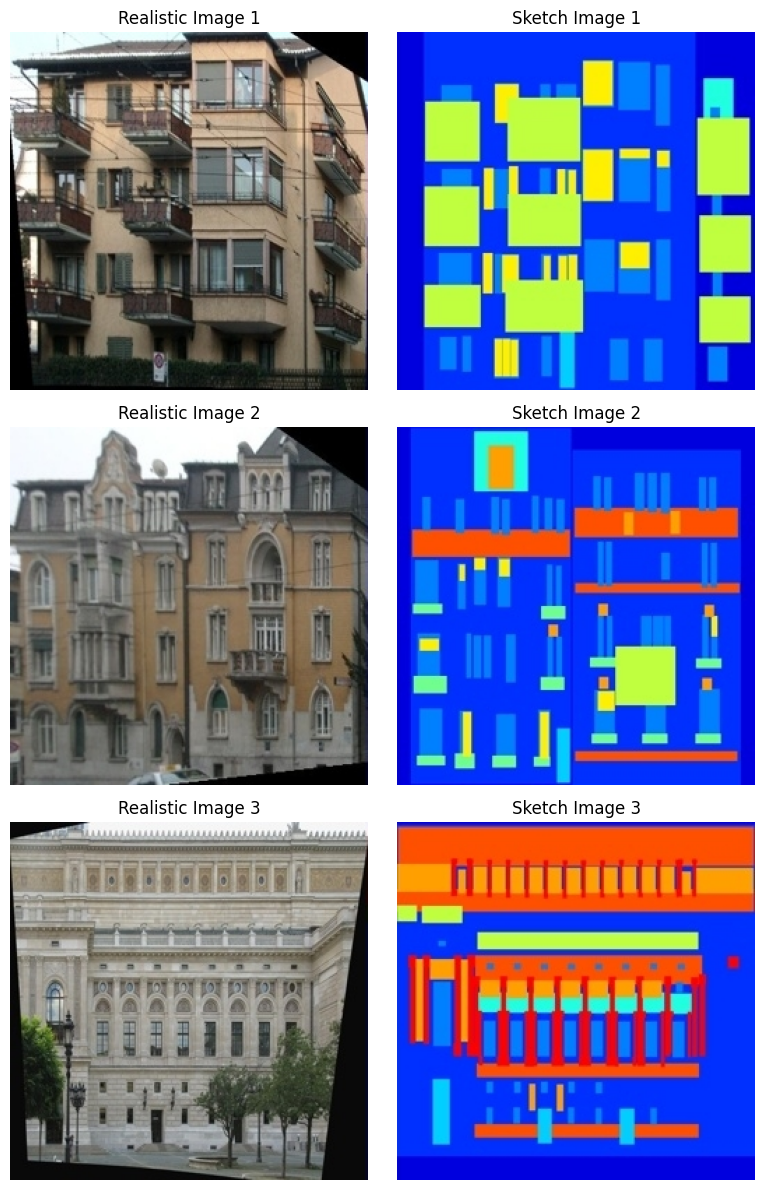

In [25]:
# random samples
random_indices = random.sample(range(len(train_images_realistes_paths)), 3)
fig, ax = plt.subplots(3, 2, figsize=(8, 12))

for i, idx in enumerate(random_indices):
    realistic_img = mpimg.imread(train_images_realistes_paths[idx])
    sketch_img = mpimg.imread(train_croquis_paths[idx])
    
    ax[i, 0].imshow(realistic_img)
    ax[i, 0].set_title(f'Realistic Image {i+1}')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(sketch_img)
    ax[i, 1].set_title(f'Sketch Image {i+1}')
    ax[i, 1].axis('off') 

plt.tight_layout()
plt.show()

# Preprocessing (Data augmentation + resize + pipeline)

In [27]:
def data_aug(croq, image):
    # random crop
    stacked = tf.concat([croq, image], axis=-1)
    stacked = tf.image.random_crop(stacked, size=[128, 128, 6])
    croq, image = stacked[:, :, :3], stacked[:, :, 3:]
    
    # random flip
    if tf.random.uniform(()) > 0.5:
        croq = tf.image.flip_left_right(croq)
        image = tf.image.flip_left_right(image)
    
    # color jittering
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    image = tf.clip_by_value(image, -1.0, 1.0)
    
    return croq, image

### Training dataset with augmentation

In [30]:
BATCH_SIZE = 8
BUFFER_SIZE = 100

In [32]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_croquis_paths, train_images_realistes_paths))
train_dataset = train_dataset.map(
    lambda croquis_path, image_path: (
        tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(croquis_path), channels=3), [140, 140]),
        tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3), [140, 140])
    ),
    num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda croquis, image: ((croquis / 127.5) - 1, (image / 127.5) - 1)
).map(
    data_aug, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)


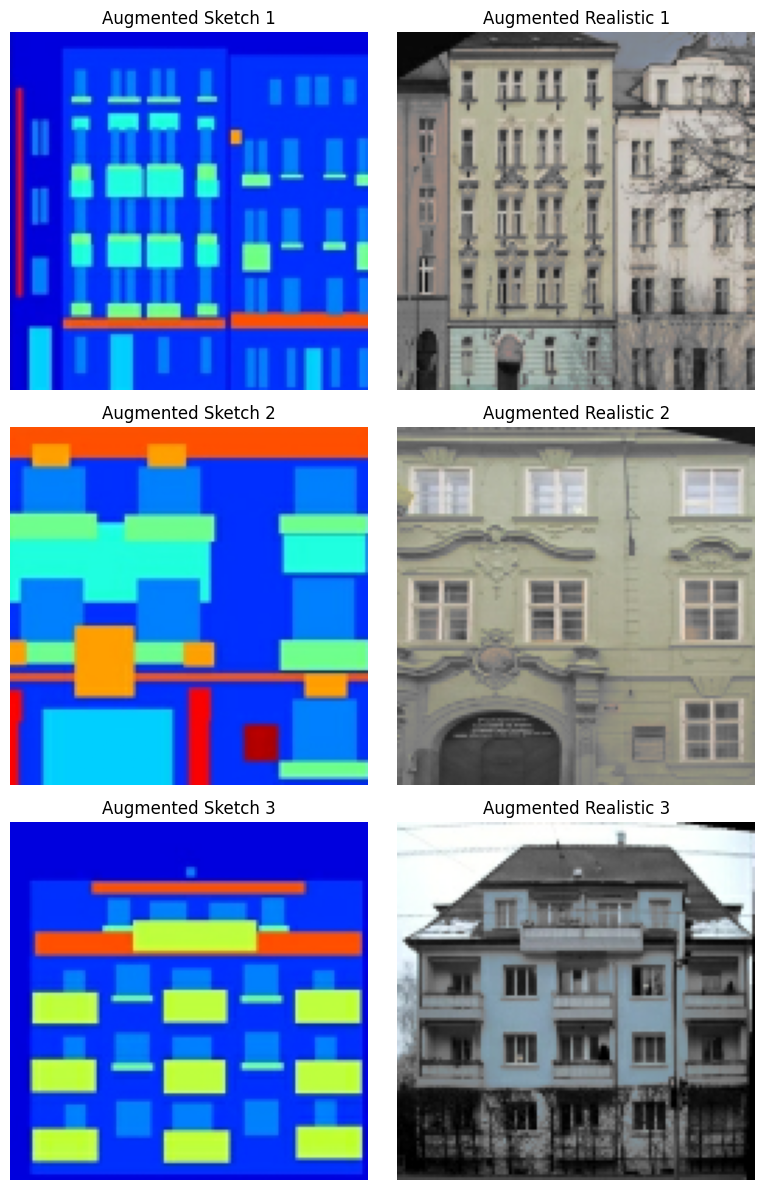

In [38]:
# random augmented data sample
for croquis, image in train_dataset.take(1):
    random_indices = random.sample(range(BATCH_SIZE), 3)
    
    fig, ax = plt.subplots(3, 2, figsize=(8, 12)) 
    for i, idx in enumerate(random_indices):
        croquis_img = croquis[idx].numpy()
        image_img = image[idx].numpy()

        ax[i, 0].imshow((croquis_img + 1) / 2)  
        ax[i, 0].set_title(f'Augmented Sketch {i+1}')
        ax[i, 0].axis('off')  
        
        ax[i, 1].imshow((image_img + 1) / 2) 
        ax[i, 1].set_title(f'Augmented Realistic {i+1}')
        ax[i, 1].axis('off') 
    
    plt.tight_layout()
    plt.show()


### Test dataset (no augmentation)

In [35]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_croquis_paths, test_images_realistes_paths))
test_dataset = test_dataset.map(
    lambda croquis_path, image_path: (
        tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(croquis_path), channels=3), [128, 128]),
        tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3), [128, 128])
    ),
    num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda croquis, image: ((croquis / 127.5) - 1, (image / 127.5) - 1)
).batch(BATCH_SIZE).prefetch(1)

# Model architecture: Pix2Pix

### Generator (U-Net Architecture)

The generator is a U-Net model, consisting of an encoder-decoder structure with skip connections. The encoder uses a series of Conv2D layers with LeakyReLU activations and BatchNormalization to downsample the input sketch into a high-dimensional latent space.  
The bottleneck layer captures high-level features.   
The decoder employs Conv2DTranspose layers with ReLU activations and skip connections from the encoder to upsample and reconstruct the output image.

In [40]:
#input
inputs = tf.keras.Input(shape=(128, 128, 3))

# encoder
# encoder unit 1
e1 = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
e1 = tfa.layers.InstanceNormalization()(e1)
e1 = tf.keras.layers.LeakyReLU(0.2)(e1)
# encoder unit 2
e2 = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(e1)
e2 = tfa.layers.InstanceNormalization()(e2)
e2 = tf.keras.layers.LeakyReLU(0.2)(e2)
# encoder unit 3
e3 = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(e2)
e3 = tfa.layers.InstanceNormalization()(e3)
e3 = tf.keras.layers.LeakyReLU(0.2)(e3)
# encoder unit 4
e4 = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same')(e3)
e4 = tfa.layers.InstanceNormalization()(e4)
e4 = tf.keras.layers.LeakyReLU(0.2)(e4)

# bottleneck
b = tf.keras.layers.Conv2D(512, 4, strides=2, padding='same')(e4)
b = tfa.layers.InstanceNormalization()(b)
b = tf.keras.layers.LeakyReLU(0.2)(b)

# decoder
# decoder unit 1
d1 = tf.keras.layers.Conv2DTranspose(512, 4, strides=2, padding='same')(b)
d1 = tf.keras.layers.Concatenate()([d1, e4])
d1 = tfa.layers.InstanceNormalization()(d1)
d1 = tf.keras.layers.ReLU()(d1)
# decoder unit 2
d2 = tf.keras.layers.Conv2DTranspose(256, 4, strides=2, padding='same')(d1)
d2 = tf.keras.layers.Concatenate()([d2, e3])
d2 = tfa.layers.InstanceNormalization()(d2)
d2 = tf.keras.layers.ReLU()(d2)
# decoder unit 3
d3 = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same')(d2)
d3 = tf.keras.layers.Concatenate()([d3, e2])
d3 = tfa.layers.InstanceNormalization()(d3)
d3 = tf.keras.layers.ReLU()(d3)
# decoder unit 4
d4 = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same')(d3)
d4 = tf.keras.layers.Concatenate()([d4, e1])
d4 = tfa.layers.InstanceNormalization()(d4)
d4 = tf.keras.layers.ReLU()(d4)

# output
output = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(d4)

generator = tf.keras.Model(inputs, output)

### Discriminator (PatchGAN)
The discriminator is a PatchGAN classifier, which operates on local image patches rather than the entire image. It takes a concatenated pair of sketch and image (real or generated) as input, forming a 128x128x6 tensor. The model consists of two Conv2D layers with LeakyReLU activations and BatchNormalization, followed by a Flatten layer and a Dense(1) output layer. Instead of using a sigmoid activation, it outputs a single logit value for each patch, enabling it to classify whether the patch is real or fake. This patch-based approach allows the discriminator to focus on fine-grained details and high-frequency structures in the image.

In [42]:
# input
inputs = tf.keras.Input(shape=(128, 128, 6)) 

# layers
x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
x = tfa.layers.InstanceNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
x = tfa.layers.InstanceNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)
x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same')(x)
x = tfa.layers.InstanceNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)

# output layer
outputs = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)

discriminator = tf.keras.Model(inputs, outputs)

### Training setup

In [45]:
initial_learning_rate = 0.0002
# learning rate schedule (dynamically adjusts the learning rate during training).
# lr decays after 10000 steps.
# the decay allows the model to make smaller adjustments as it approaches convergence.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)

In [47]:
# adam optimizer for both the generator and descriminator networks
# the momentum parameter (beta_1) controls how much past gradients influence the current update.
# a value of 0.5 is commonly used in GANs to stabalize training.

gen_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=0.5)

In [49]:
# loss function: binary cross entropy (binary classification task, here it distinguishes between 
# real and fake images in GANs).
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [51]:
# regularization weights: used for weighting different loss terms.
LAMBDA_L1 = 100
LAMBDA_FEATURE = 10

In [53]:
# feature extractor: encourages the generator to produce images that share similar features
#with real images in the descriminator.

feature_extractor = tf.keras.Model(
    inputs=discriminator.inputs,
    outputs=discriminator.layers[-3].output  # Get layer before last conv
)

### Training loop

In [56]:
# history for tracking losses and metrics
history = {
    "generator_loss": [],
    "gan_loss": [],
    "l1_loss": [],
    "feature_loss": [],
    "discriminator_loss": [],
    "time_per_epoch": []
}

In [58]:
# training loop for 100 epochs
for epoch in range(100): 
    start = time.time()
    
    for croquis_batch, images_realistes_batch in train_dataset:
        with tf.GradientTape(persistent=True) as tape:
            # generate images
            generated_images = generator(croquis_batch, training=True)
            
            # discriminator inputs
            real_pairs = tf.concat([croquis_batch, images_realistes_batch], axis=-1)
            fake_pairs = tf.concat([croquis_batch, generated_images], axis=-1)
            
            # discriminator evaluations
            disc_real = discriminator(real_pairs, training=True)
            disc_fake = discriminator(fake_pairs, training=True)
            
            # feature matching loss
            features_real = feature_extractor(real_pairs)
            features_fake = feature_extractor(fake_pairs)
            feature_loss = tf.reduce_mean(tf.abs(features_real - features_fake))
            
            # generator loss
            gan_loss = loss_fn(tf.ones_like(disc_fake), disc_fake)
            l1_loss = LAMBDA_L1 * tf.reduce_mean(tf.abs(images_realistes_batch - generated_images))
            total_gen_loss = gan_loss + l1_loss + LAMBDA_FEATURE * feature_loss
            
            # discriminator loss
            disc_loss_real = loss_fn(tf.ones_like(disc_real), disc_real)
            disc_loss_fake = loss_fn(tf.zeros_like(disc_fake), disc_fake)
            total_disc_loss = (disc_loss_real + disc_loss_fake) * 0.5

        # apply gradients
        gen_grads = tape.gradient(total_gen_loss, generator.trainable_variables)
        disc_grads = tape.gradient(total_disc_loss, discriminator.trainable_variables)
        
        gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
    
    # recording
    history["generator_loss"].append(total_gen_loss.numpy())
    history["gan_loss"].append(gan_loss.numpy())
    history["l1_loss"].append(l1_loss.numpy())
    history["feature_loss"].append(feature_loss.numpy())
    history["discriminator_loss"].append(total_disc_loss.numpy())
    history["time_per_epoch"].append(time.time() - start)
    
    # tracking progress
    print(f'Epoch {epoch+1}')
    print(f'[Generator] Loss: {total_gen_loss.numpy():.2f} (GAN: {gan_loss.numpy():.2f}, L1: {l1_loss.numpy():.2f}, Feature: {feature_loss.numpy():.2f})')
    print(f'[Discriminator] Loss: {total_disc_loss.numpy():.2f}')
    print(f'Time: {history["time_per_epoch"][-1]:.1f}s\n')

Epoch 1
[Generator] Loss: 40.72 (GAN: 1.31, L1: 31.85, Feature: 0.76)
[Discriminator] Loss: 0.41
Time: 23.2s

Epoch 2
[Generator] Loss: 41.96 (GAN: 1.07, L1: 32.95, Feature: 0.79)
[Discriminator] Loss: 0.37
Time: 15.1s

Epoch 3
[Generator] Loss: 37.88 (GAN: 2.00, L1: 28.49, Feature: 0.74)
[Discriminator] Loss: 0.23
Time: 14.4s

Epoch 4
[Generator] Loss: 43.49 (GAN: 1.48, L1: 33.77, Feature: 0.82)
[Discriminator] Loss: 0.22
Time: 14.0s

Epoch 5
[Generator] Loss: 40.02 (GAN: 1.39, L1: 31.53, Feature: 0.71)
[Discriminator] Loss: 0.35
Time: 15.6s

Epoch 6
[Generator] Loss: 45.93 (GAN: 1.43, L1: 36.31, Feature: 0.82)
[Discriminator] Loss: 0.29
Time: 15.4s

Epoch 7
[Generator] Loss: 41.77 (GAN: 2.01, L1: 32.22, Feature: 0.75)
[Discriminator] Loss: 0.24
Time: 14.6s

Epoch 8
[Generator] Loss: 39.20 (GAN: 1.41, L1: 30.68, Feature: 0.71)
[Discriminator] Loss: 0.24
Time: 15.2s

Epoch 9
[Generator] Loss: 41.96 (GAN: 1.50, L1: 32.68, Feature: 0.78)
[Discriminator] Loss: 0.24
Time: 14.4s

Epoch 10
[

# Model evaluation

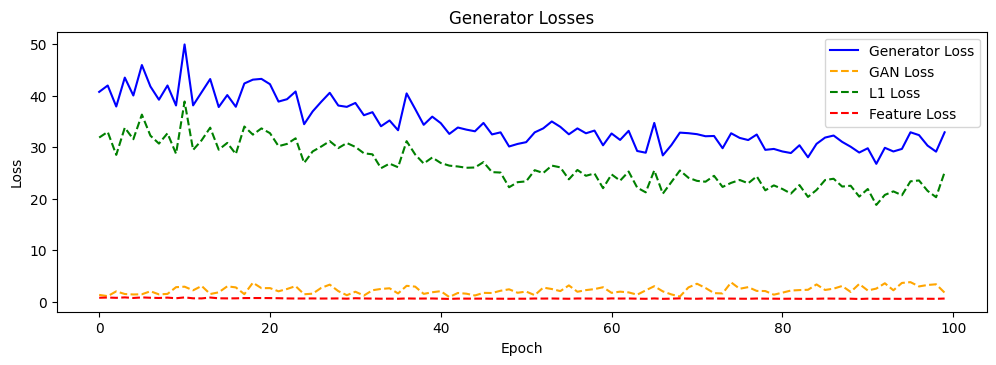

In [93]:
plt.figure(figsize=(12, 8))
# generator losses
plt.subplot(2, 1, 1)
plt.plot(history["generator_loss"], label="Generator Loss", color="blue")
plt.plot(history["gan_loss"], label="GAN Loss", linestyle="--", color="orange")
plt.plot(history["l1_loss"], label="L1 Loss", linestyle="--", color="green")
plt.plot(history["feature_loss"], label="Feature Loss", linestyle="--", color="red")
plt.title("Generator Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

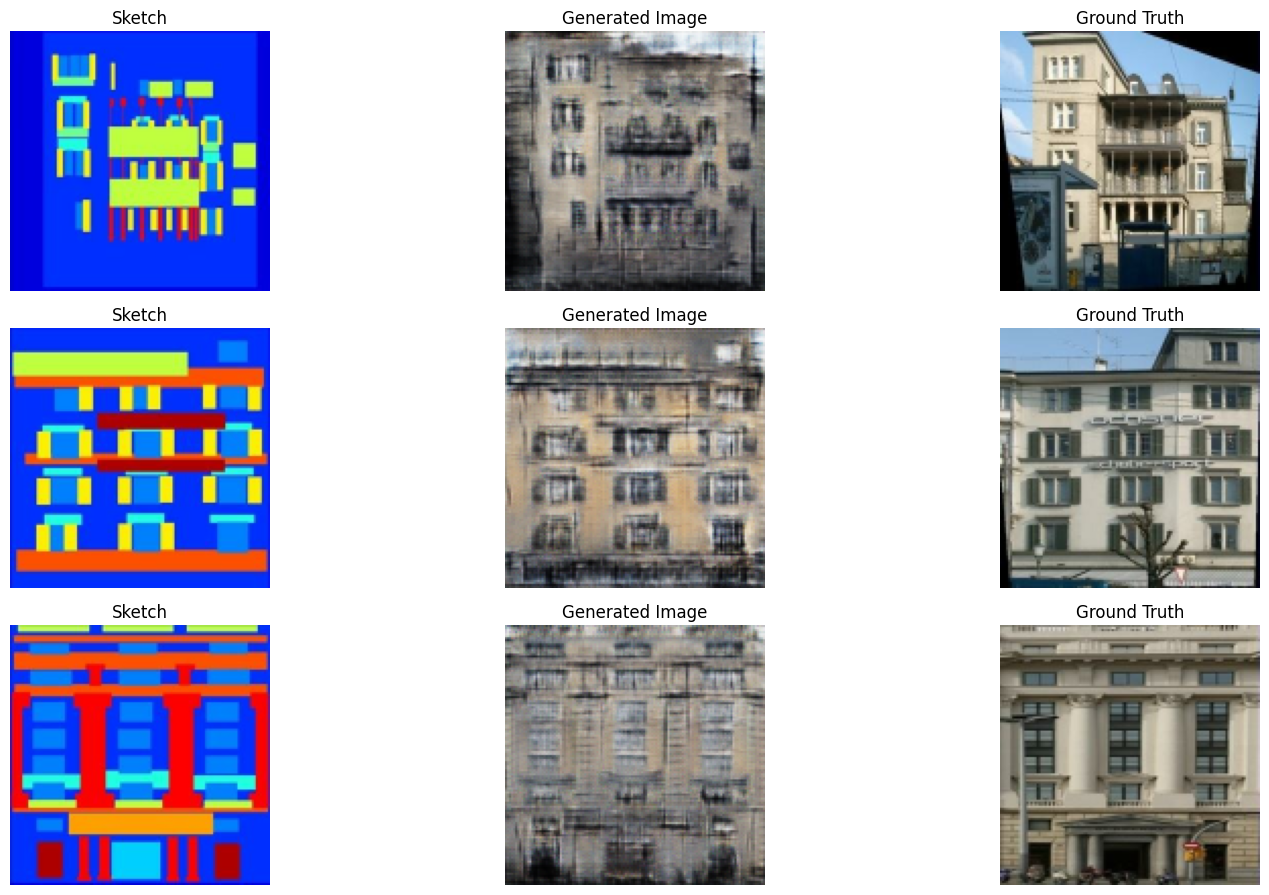

In [81]:
plt.figure(figsize=(15, 15))

for i, (croquis_batch, images_realistes_batch) in enumerate(test_dataset.take(3)):
    generated_images = generator(croquis_batch, training=False)
    for j in range(len(croquis_batch)):
        plt.subplot(5, 3, i*3 + 1)
        plt.imshow((croquis_batch[j] + 1) / 2) 
        plt.title("Sketch")
        plt.axis('off')
        plt.subplot(5, 3, i*3 + 2)
        plt.imshow((generated_images[j] + 1) / 2) 
        plt.title("Generated Image")
        plt.axis('off')
        plt.subplot(5, 3, i*3 + 3)
        plt.imshow((images_realistes_batch[j] + 1) / 2) 
        plt.title("Ground Truth")
        plt.axis('off')

plt.tight_layout()
plt.show()

=> The generated images from the model do not appear to be very realistic.  
The colors appear to be uniform accross the generated images. Additionally, the shapes and edges of the generated images appear deformed, with missing in fine details, such as misaligned contours and unnatural textures. This could be due to the model's architecture or the training process not capturing the finer details of the real images effectively.

***Possible improvements***:
  
-Experimenting with a more sophisticated generator architecture, such as using deeper layers or incorporating advanced techniques like attention mechanisms or residual connections, could help the model learn more complex features, and we can use more advanced methods for learning image features such as diffusion.
  
-Augmenting the dataset with more diverse images and applying advanced data preprocessing techniques could increase the variety of features the model learns, leading to better generalization. 
  
-Tuning the loss functions and incorporating perceptual loss, which compares features between real and generated images, might enhance the overall image quality by focusing on maintaining the structure and details of the images during training.